### Pandemic Flu Spread Simulation

Author - Nuwan **Werellagama**

In [ ]:
!pip install simpy

### Setup

In [ ]:
import numpy as np
import simpy as sp
import matplotlib.pyplot as plt

from collections import defaultdict


RANDOM_SEED = 32               # Seed for reproducible results
NUM_STUDENTS = 60              # Number of uninfected students
PROB_INFECTION = 0.01          # Probability of getting infected

DAYS = 10                      # Simulation time in days
INCUBATION_TIME = 1            # Incubation time in days
ITERATIONS = 10000             # Number of iterations to simulate


class Student:
  """
      Student describes a student who is suspectible to getting infected

      Attributes,
        name - uniquely identify each student
        infected - boolean indicating if the student is infected
        infected_at - a timestamp indicating when the student was infected
        immune - describes if the student is immune. Not immune by default

  """
  def __init__(self, env, name, infected=False, infected_at=-1,immune=False):
    self.env = env
    self.name = name
    self.infected = infected
    self.infected_at = infected_at
    self.immune = immune

class School:
  """
      School describes a class holding susceptible students.

      Attributes,
      - students - A list of students
      - recovered - A dictionary of recovered students per day
      - infected - A dictionary of infected students per day
  """
  def __init__(self, env, number_of_students, set_immunity_factor=False):
    # Add uninfected students
    self.students = [
        Student(
            env,
            i,
            # Assign immunity factor with 50-50 chance
            immune=np.random.uniform(0, 1) > 0.5 if set_immunity_factor else False)
        for i in range(1, number_of_students + 1)]
    # Add Tommy as an infected student
    self.students.append(
        Student(
            env,
            'Tommy',
            infected=True,
            infected_at=env.now))
    self.env = env
    # Indicates recovered students per day
    self.recovered = defaultdict(int)
    # Indications infected students per day
    self.infected = defaultdict(int)

  def day_at_school(self):
    while True:
      yield self.env.timeout(INCUBATION_TIME)

      day_n = self.env.now

      noninfected = [s for s in self.students
                    if s.infected == False
                    and (s.name != 'Tommy' and day_n <= 4)]

      binom_trials = np.random.binomial(
          n=1,
          p=PROB_INFECTION,
          size=len(noninfected))

      # If uninfected mark these students as infected
      for index, prob in enumerate(binom_trials):
        if (prob == 1 and self.students[index].immune == False):
          self.students[index].infected = True
          self.students[index].infected_at = self.env.now
          self.infected[day_n] += 1

      # Check for infected students who might be recovered now
      for index, s in enumerate(self.students):
        if (s.infected
            and self.env.now - s.infected_at > 3):
            self.students[index].infected = False
            self.students[index].infected_at = -1
            self.students[index].immune = True
            self.recovered[day_n] += 1

      # print stats (set print=True to print)
      self.stats_per_day(day_n)


  def stats_per_day(self, day, print=False):
      total_infected_count = sum([1 for s in self.students
                                  if s.infected == True])
      recovered_count = self.recovered[day]
      infected_count = self.infected[day]

      if (print):
        print(f'DAY {day} at school')
        print(f'{infected_count} infected')
        print(f'{recovered_count} recovered')
        print(f'{total_infected_count} total infected')
        print(f'{(total_infected_count/(len(self.students)))*100:2.2f}% total infected')
        print(f'======================================')

# global dictionaries
infections = defaultdict(list)
recoveries = defaultdict(list)

# Define a run per simulation
def run_simulation(iteration, set_immunity_factor=False):
  # Setup and start simulation
  env = sp.Environment()

  # Setup
  school = School(env, NUM_STUDENTS, set_immunity_factor)

  # Execute!
  env.process(school.day_at_school())
  env.run(until=DAYS)

  # Aggregate infection values per iteration
  infections[iteration] = [v for v in school.infected.values()]

  # Aggregate recovery values per iteration
  recoveries[iteration] = [v for v in school.recovered.values()]

### Run Simulation Scenario 1

Here, the simulation is run without students having immunity. The graph below shows the number of infected students and recovered students over time indicating how long the pandemic will last.

Pandemic Simulation
Simulation without immunity
Day 1 expected infected value - 0.5974
Day 2 expected infected value - 0.5987
Day 3 expected infected value - 0.5936
Day 4 expected infected value - 0.5961
Day 5 expected infected value - 0.0
Day 6 expected infected value - 0.0
Day 7 expected infected value - 0.0
Day 8 expected infected value - 0.0
Day 9 expected infected value - 0.0


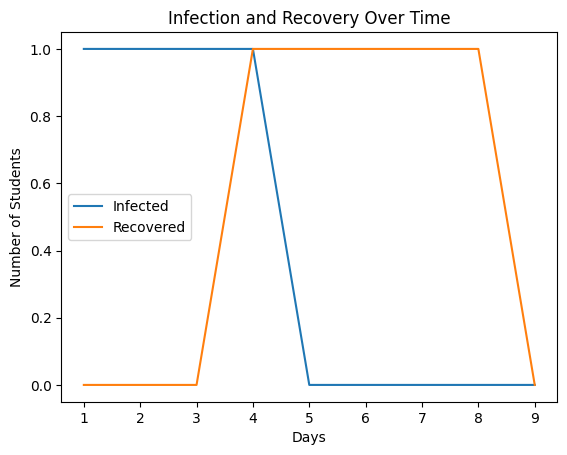

In [ ]:
# global dictionaries
infections = defaultdict(list)
recoveries = defaultdict(list)

print(f'Pandemic Simulation Scenario 1')
print(f'Simulation without immunity')
print(f'===========================')

for i in range(ITERATIONS):
  run_simulation(i)

infected_mean = []
recovered_mean = []
for d in range(DAYS-1):
  day_n_infections = [v[d] for v in infections.values()]
  day_n_recoveries = [v[d] for v in recoveries.values()]
  print(f'Day {d+1} expected infected value - {np.mean(day_n_infections)}')
  infected_mean.append(np.ceil(np.mean(day_n_infections)))
  recovered_mean.append(np.ceil(np.mean(day_n_recoveries)))

# Plot infected and recovered students
days = range(1, len(infected_mean) + 1)  # X-axis values (days)

plt.plot(days, infected_mean, label='Infected')
plt.plot(days, recovered_mean, label='Recovered')

plt.xlabel('Days')
plt.ylabel('Number of Students')
plt.title('Infection and Recovery Over Time')
plt.legend()

plt.show()

### Run simulation scenario 2

Here, the simulation is run, but now students are immune with a 50-50 chance.

Pandemic Simulation Scenario 2
Simulation with immunity
Day 1 expected infected value - 0.3001
Day 2 expected infected value - 0.2996
Day 3 expected infected value - 0.2977
Day 4 expected infected value - 0.2941
Day 5 expected infected value - 0.0
Day 6 expected infected value - 0.0
Day 7 expected infected value - 0.0
Day 8 expected infected value - 0.0
Day 9 expected infected value - 0.0


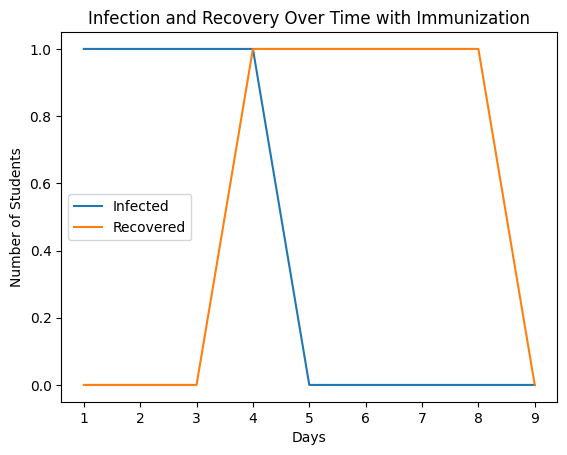

In [ ]:
# global dictionaries
infections = defaultdict(list)
recoveries = defaultdict(list)

print(f'Pandemic Simulation Scenario 2')
print(f'Simulation with immunity')
print(f'===========================')

for i in range(ITERATIONS):
  run_simulation(i, set_immunity_factor=True)

infected_mean = []
recovered_mean = []
for d in range(DAYS-1):
  day_n_infections = [v[d] for v in infections.values()]
  day_n_recoveries = [v[d] for v in recoveries.values()]
  print(f'Day {d+1} expected infected value - {np.mean(day_n_infections)}')
  infected_mean.append(np.ceil(np.mean(day_n_infections)))
  recovered_mean.append(np.ceil(np.mean(day_n_recoveries)))

# Plot infected and recovered students
days = range(1, len(infected_mean) + 1)  # X-axis values (days)

plt.plot(days, infected_mean, label='Infected')
plt.plot(days, recovered_mean, label='Recovered')

plt.xlabel('Days')
plt.ylabel('Number of Students')
plt.title('Infection and Recovery Over Time with Immunization')
plt.legend()

plt.show()